# Примена на регресиони модели за предвидување на потрошувачка на електрична енергија

## Data preparation

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [3]:
train

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0
...,...,...,...,...,...,...,...,...
26491,34891,2017-06-23 19:00:00,-0.7,-15.0,1009.0,51.685,A,225.0
26492,34892,2017-06-23 20:00:00,-2.9,-11.4,1005.0,56.105,A,213.0
26493,34893,2017-06-23 21:00:00,-1.4,-12.9,995.0,61.275,A,213.0
26494,34894,2017-06-23 22:00:00,-2.9,-11.4,996.0,67.210,A,210.0


In [4]:
test

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A
...,...,...,...,...,...,...,...
8563,35059,2017-06-30 19:00:00,-5.7,-18.6,998.0,233.595,A
8564,35060,2017-06-30 20:00:00,-5.7,-17.1,995.0,238.780,A
8565,35061,2017-06-30 21:00:00,-7.1,-19.3,1004.0,244.325,A
8566,35062,2017-06-30 22:00:00,-6.4,-19.3,1008.0,247.470,A


In [5]:
le = LabelEncoder()
train['var2'] = le.fit_transform(train['var2'])
test['var2'] = le.fit_transform(test['var2'])
train

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,0,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,0,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,0,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,0,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,0,222.0
...,...,...,...,...,...,...,...,...
26491,34891,2017-06-23 19:00:00,-0.7,-15.0,1009.0,51.685,0,225.0
26492,34892,2017-06-23 20:00:00,-2.9,-11.4,1005.0,56.105,0,213.0
26493,34893,2017-06-23 21:00:00,-1.4,-12.9,995.0,61.275,0,213.0
26494,34894,2017-06-23 22:00:00,-2.9,-11.4,996.0,67.210,0,210.0


In [6]:
train.describe()

,ID,temperature,var1,pressure,windspeed,var2,electricity_consumption
count,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000
mean,17455.500000,5.098989,-1.916233,986.450615,23.959956,0.086692,298.359601
std,10122.873673,8.682860,10.424860,12.002647,48.280321,0.397096,108.020555
min,0.000000,-17.100000,-32.900000,953.000000,1.075000,0.000000,174.000000
25%,8717.750000,-2.900000,-10.700000,978.000000,3.155000,0.000000,219.000000
50%,17435.500000,6.400000,-1.400000,986.000000,6.545000,0.000000,267.000000
75%,26177.250000,12.100000,7.900000,995.000000,22.260000,0.000000,342.000000
max,34895.000000,23.600000,18.600000,1024.000000,586.600000,2.000000,1386.000000


In [7]:
test.describe()

,ID,temperature,var1,pressure,windspeed,var2
count,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000
mean,17766.525210,5.112757,-1.726401,986.329599,24.176398,0.083450
std,10117.296415,8.606167,10.345034,12.148517,49.651535,0.390044
min,552.000000,-17.900000,-26.400000,954.000000,1.075000,0.000000
25%,9317.750000,-2.100000,-10.000000,977.000000,3.155000,0.000000
50%,18083.500000,5.700000,-2.100000,987.000000,6.295000,0.000000
75%,26297.250000,12.100000,7.900000,995.000000,21.907500,0.000000
max,35063.000000,25.700000,17.900000,1023.000000,491.255000,2.000000


## Visualizations

<AxesSubplot:title={'center':'Electricity consumption'}, ylabel='electricity_consumption'>

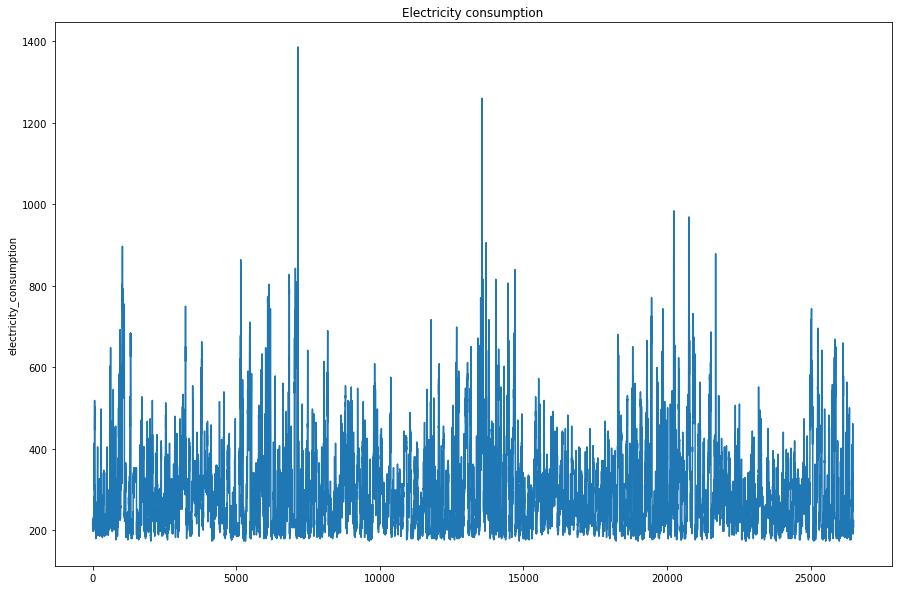

In [8]:
plt.figure(figsize=(15, 10))
plt.title('Electricity consumption')
sns.lineplot(data=train['electricity_consumption'])

<AxesSubplot:title={'center':'Temperature'}, ylabel='temperature'>

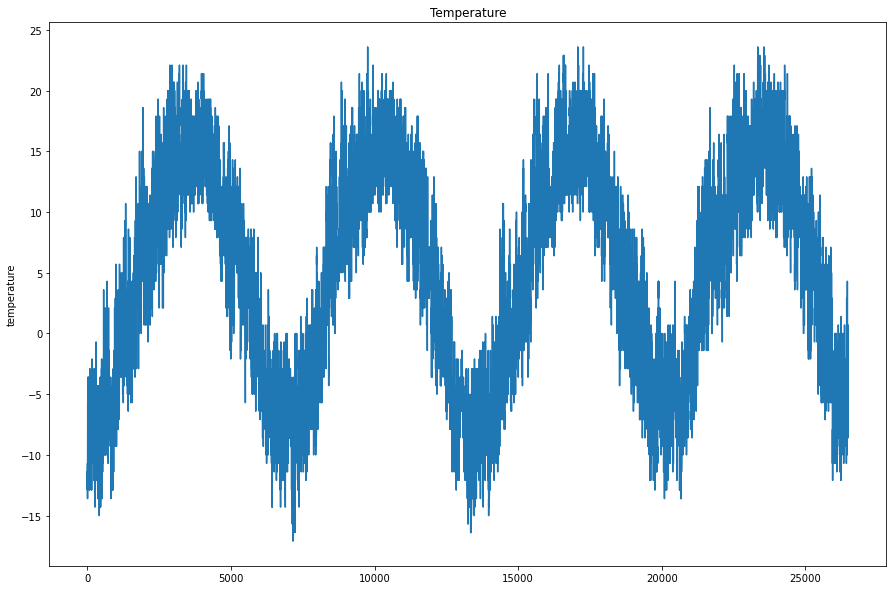

In [9]:
plt.figure(figsize=(15, 10))
plt.title('Temperature')
sns.lineplot(data=train['temperature'])

<AxesSubplot:title={'center':'Pressure'}, ylabel='pressure'>

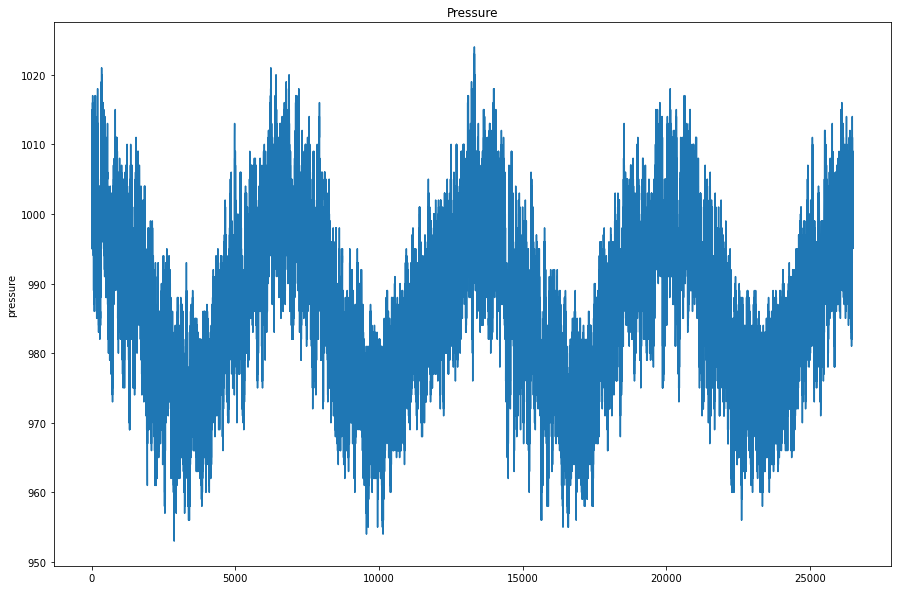

In [10]:
plt.figure(figsize=(15, 10))
plt.title('Pressure')
sns.lineplot(data=train['pressure'])

<AxesSubplot:title={'center':'Windspeed'}, ylabel='windspeed'>

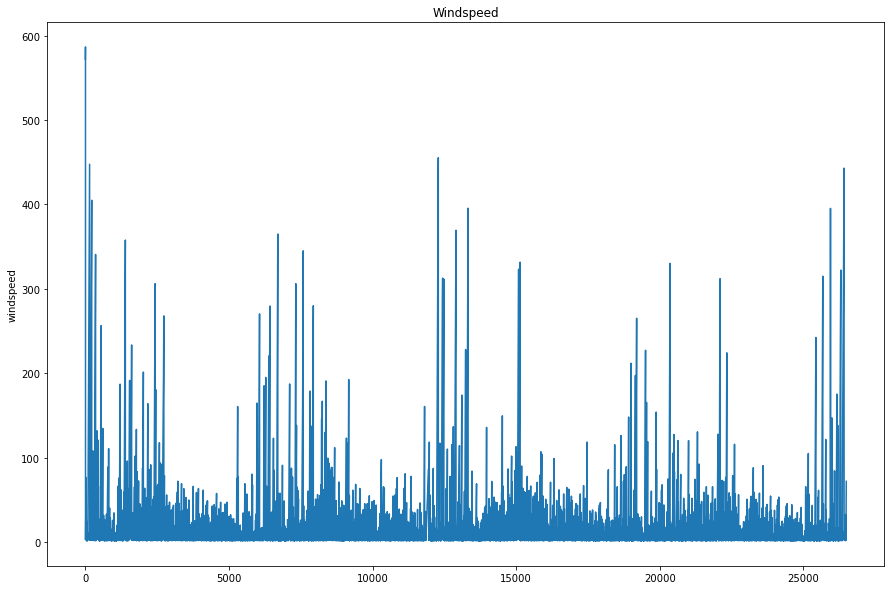

In [11]:
plt.figure(figsize=(15, 10))
plt.title('Windspeed')
sns.lineplot(data=train['windspeed'])

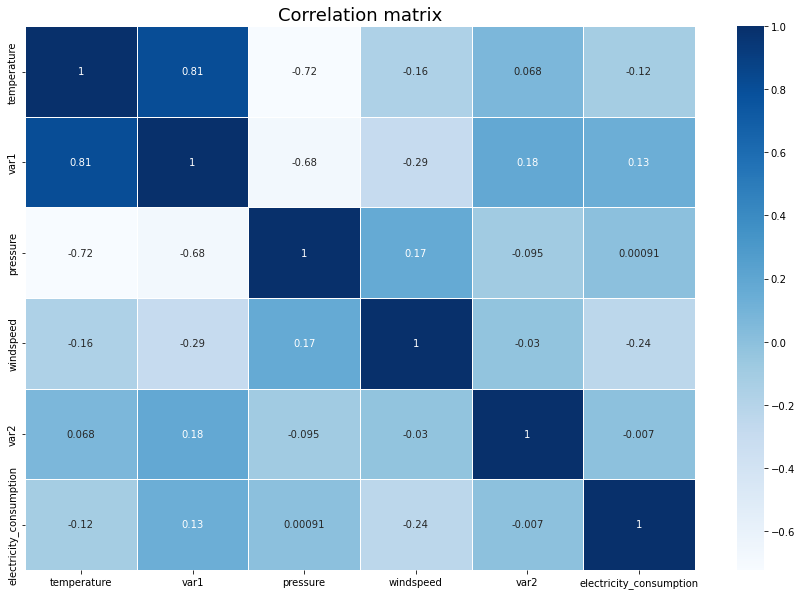

In [12]:
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(train.loc[:, 'temperature':].corr(), linewidths=1, annot=True, cmap='Blues')
ax.set_title('Correlation matrix', size=18)
plt.show()

## Splitting the datasets

In [13]:
X_train = train.iloc[:, 2:-1]
X_test = test.iloc[:, 2:]
Y_train = train.iloc[:, -1]
X_train

,temperature,var1,pressure,windspeed,var2
0,-11.4,-17.1,1003.0,571.910,0
1,-12.1,-19.3,996.0,575.040,0
2,-12.9,-20.0,1000.0,578.435,0
3,-11.4,-17.1,995.0,582.580,0
4,-11.4,-19.3,1005.0,586.600,0
...,...,...,...,...,...
26491,-0.7,-15.0,1009.0,51.685,0
26492,-2.9,-11.4,1005.0,56.105,0
26493,-1.4,-12.9,995.0,61.275,0
26494,-2.9,-11.4,996.0,67.210,0


## Regression Models

### Linear Regression

In [14]:
linear = LinearRegression().fit(X_train, Y_train)
Y_pred_linear = linear.predict(X_test)
Y_pred_linear_df = pd.DataFrame(Y_pred_linear, columns = ['Linear'])

### Ridge Regression

In [15]:
ridge = Ridge().fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
Y_pred_ridge_df = pd.DataFrame(Y_pred_ridge, columns = ['Ridge'])

### Lasso Regression

In [16]:
lasso = Lasso().fit(X_train, Y_train)
Y_pred_lasso = lasso.predict(X_test)
Y_pred_lasso_df = pd.DataFrame(Y_pred_lasso, columns = ['Lasso'])

### ElasticNet Regression

In [17]:
elasticNet = ElasticNet().fit(X_train, Y_train)
Y_pred_elasticNet = elasticNet.predict(X_test)
Y_pred_elasticNet_df = pd.DataFrame(Y_pred_elasticNet, columns = ['ElasticNet'])

### Polynomial Regression

In [18]:
polynomial = PolynomialFeatures(degree=4)
X_polynomial = polynomial.fit_transform(X_train)
polynomial.fit(X_polynomial, Y_train)
linear2 = LinearRegression().fit(X_polynomial, Y_train)
Y_pred_linear2 = linear2.predict(polynomial.fit_transform(X_test))
Y_pred_polynomial_df = pd.DataFrame(Y_pred_linear2, columns = ['Polynomial'])

### Bayesian Ridge Regression

In [19]:
bayesianRidge = BayesianRidge().fit(X_train, Y_train)
Y_pred_bayesianRidge = bayesianRidge.predict(X_test)
Y_pred_bayesianRidge_df = pd.DataFrame(Y_pred_bayesianRidge, columns = ['BayesianRidge'])

### LSTM

In [21]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm.add(LSTM(units=25))
lstm.add(Dense(units=1))

lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
828/828 [==============================] - 15s 13ms/step - loss: 91345.9688
Epoch 2/20
828/828 [==============================] - 10s 11ms/step - loss: 79568.2109
Epoch 3/20
828/828 [==============================] - 10s 12ms/step - loss: 69357.3750
Epoch 4/20
828/828 [==============================] - 9s 11ms/step - loss: 60207.8359
Epoch 5/20
828/828 [==============================] - 9s 11ms/step - loss: 51989.3516
Epoch 6/20
828/828 [==============================] - 10s 12ms/step - loss: 44656.3203
Epoch 7/20
828/828 [==============================] - 10s 12ms/step - loss: 38162.2070
Epoch 8/20
828/828 [==============================] - 10s 12ms/step - loss: 32468.4453
Epoch 9/20
828/828 [==============================] - 10s 12ms/step - loss: 27555.9707
Epoch 10/20
828/828 [==============================] - 10s 12ms/step - loss: 23398.8633
Epoch 11/20
828/828 [==============================] - 11s 13ms/step - loss: 19969.0586
Epoch 12/20
828/828 [======================

In [44]:
Y_pred_lstm = lstm.predict(X_test)
Y_pred_lstm_df = pd.DataFrame(Y_pred_lstm, columns = ['LSTM'])

## Summary

In [46]:
predicted_electricity_consumption = pd.concat([test['datetime'], Y_pred_linear_df, Y_pred_ridge_df, Y_pred_lasso_df,
                                               Y_pred_elasticNet_df, Y_pred_polynomial_df, Y_pred_bayesianRidge_df,
                                               Y_pred_lstm_df], axis=1)
predicted_electricity_consumption

,datetime,Linear,Ridge,Lasso,ElasticNet,Polynomial,BayesianRidge,LSTM
0,2013-07-24 00:00:00,236.391505,236.390727,235.330975,232.497761,218.846710,236.328196,209.354782
1,2013-07-24 01:00:00,207.786464,207.786080,207.337659,205.813551,229.994408,207.755171,207.816788
2,2013-07-24 02:00:00,238.781049,238.780204,237.467120,234.326758,219.346613,238.712218,209.113754
3,2013-07-24 03:00:00,236.726104,236.725383,235.603271,232.726572,236.608766,236.667336,208.321808
4,2013-07-24 04:00:00,335.290346,335.290169,335.028741,334.274316,296.108050,335.275956,271.245575
...,...,...,...,...,...,...,...,...
8563,2017-06-30 19:00:00,203.029452,203.029214,202.716372,201.891047,209.632051,203.010103,207.320679
8564,2017-06-30 20:00:00,211.857301,211.856888,211.223963,209.797378,210.657381,211.823675,207.559158
8565,2017-06-30 21:00:00,203.820137,203.819867,203.514979,202.521080,214.438002,203.798138,207.448410
8566,2017-06-30 22:00:00,195.217499,195.217309,195.122615,194.455658,211.894813,195.202076,207.367371
